<a href="https://colab.research.google.com/github/patricksabry1/42028-Deep-Learning/blob/master/Assessment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Image classification - 17 Flowers dataset

The baseline architecture used will be the vgg16 architecture. The original vgg16 architecture will be experimented with first, and then transfer learning will be used to adapt the pre-trained vgg16 model to the flower data. The results of both models will be evaluated and compared for accuracy and training time.


## Data pre-processing

### Initialise dependencies & mount g drive for data extraction

In [1]:
%pip install livelossplot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot import PlotLossesKerasTF
from tqdm import tqdm
from skimage import feature
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import accuracy_score
import cv2
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd /content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/

/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2


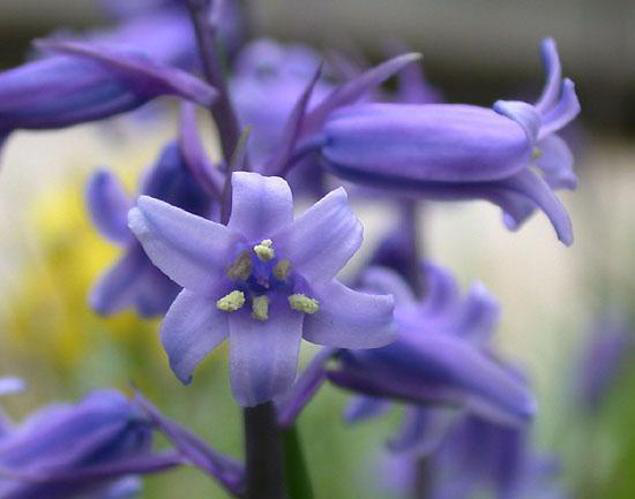

In [3]:
from PIL import Image #show one example of image
Image.open("../assignment-2/17FlowerDataset/Bluebell/image_0241.jpg")

In [0]:
def load_data(fpath):    
    img=Image.open(fpath).resize((224,224)) # resize to 299x299 for InceptionNet compatibility
    img = np.asarray(img, dtype='float32')

    return img

In [0]:
import os

# Load images as np arrays to be saved again as images later on when split into train and test subsets.
rootdir = '../assignment-2/17FlowerDataset/'
images=[]
labels=[]
total=1361
j=1
i=0
class_dict = {}
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        images.append(load_data(os.path.join(subdir, file)))
        labels.append(j) #labels are created as well
        class_dict[j] = str(subdir)
        i += 1
        if i % 80 == 0: j += 1

## Class keys
{1: 'Cowslip', 2: 'Crocus', 3: 'Buttercup', 4: 'Dandelion', 5: 'Daffodil', 6: 'Iris', 7: 'Daisy', 8: 'ColtsFoot', 9: 'Bluebell', 10: 'Fritillary', 11: 'Tigerlily', 12: 'LilyValley', 13: 'Pansy', 14: 'Snowdrop', 15: 'Windflower', 16: 'Tulip', 17: 'Sunflower'}

In [6]:
images = np.asarray(images) # all of the images are converted to np array of (1360,224,224,3)
labels = np.asarray(labels).reshape(1360,1) # labels are also converted to (1360,1)
images.shape

(1360, 224, 224, 3)

In [0]:
# Split data into training and test. Since this is a very small dataset, a 70/30 split was deemed best to avoid overfitting.
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size = 0.7, random_state =  104)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


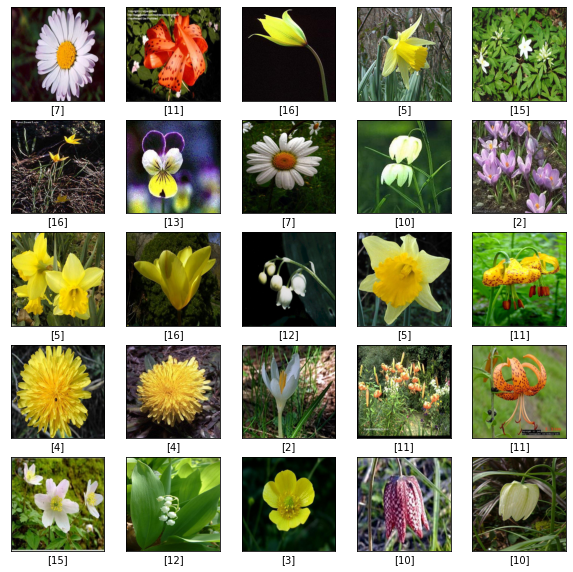

In [8]:
# plot some sample images with corresponding labels to verify image labelling.
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i]/255, cmap=plt.cm.binary)
    plt.xlabel(y_train[i])

In [0]:
# dividing images into train and test folders by creating images from arrays
import cv2
import numpy as np
def create_images(data, labels, folder):
    dirname=folder
    
    if not os.path.exists(dirname): #check if the folder exists; if not make dir
      os.mkdir(dirname)
    n=0
    
    for i in data:
      label_n=labels[n]
      subfolder = folder + "/" + str(label_n) 
      if not os.path.exists(subfolder): # create subfolders with categories
          os.mkdir(subfolder)  
      filepath =  subfolder + "/" + str(n)+ ".jpg"
      cv2.imwrite(filepath, data[n]) #save image to corresponding subfolders
      n+=1

create_images(X_train, y_train, 'train') #save image to corresponding subfolders
create_images(X_test, y_test, 'test')
train_dir =os.path.realpath('train')
validation_dir = os.path.realpath('test')
image_size = 224

## Image data augmentation


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      horizontal_flip=True,
      rotation_range=10,
      width_shift_range=0.2,
      height_shift_range=0.2,
      fill_mode='nearest'
      )
 
validation_datagen = ImageDataGenerator(rescale=1./255)

train_batchsize = 64
val_batchsize = 64
 
# Fit the train and test images onto the data generators to augment them.
train_generator = train_datagen.flow_from_directory( 
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 951 images belonging to 17 classes.
Found 409 images belonging to 17 classes.


## VGG16 implementation for 17Flowers image classification

The VGG16 model initialised with ImageNet weights will be used as a pre-trained model to conduct transfer learning on the 17Flowers dataset. The fully connected layer will not be included and substituted with our own fully connected layer to increase adaptability of the model.

### Baseline model

In [11]:
import tensorflow as tf
from tensorflow.keras import models, layers,optimizers
from keras.preprocessing import image
import tensorflow.keras.applications.vgg16
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.layers import Input, Dense

# Load the model initialised with ImageNet weights
vgg_transfer = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Use conv layers only for feature extraction
for layer in vgg_transfer.layers[:-4]:
    layer.trainable = False

# Initialise model architecture
model = tf.keras.models.Sequential()
model.add(vgg_transfer)

# Add fully connected layers and final output layer
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(17, activation='softmax'))
model.summary() 


model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=2e-4), metrics=['acc'])

Using TensorFlow backend.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                17425     
Total params: 40,423,249
Trainable params: 32,787,985
Non-trainable params: 7,635,264
_________________________________________________________________


In [13]:
# LR schedule - reduce learning rate on loss plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.001)

callbacks = [reduce_lr, tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)]

history = model.fit(
      train_generator,
      shuffle=True,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      callbacks=callbacks,
      verbose=1)


print('training acc.:', history.history['acc'][-1], '\n','test acc.:', (history.history['val_acc'])[-1])

Epoch 1/50
15/14 [==============================] - 20s 1s/step - loss: 3.0732 - acc: 0.0946 - val_loss: 2.6110 - val_acc: 0.1174 - lr: 2.0000e-04
Epoch 2/50
15/14 [==============================] - 14s 960ms/step - loss: 2.5548 - acc: 0.1356 - val_loss: 2.3725 - val_acc: 0.1980 - lr: 2.0000e-04
Epoch 3/50
15/14 [==============================] - 15s 984ms/step - loss: 2.2796 - acc: 0.2566 - val_loss: 2.0194 - val_acc: 0.3374 - lr: 2.0000e-04
Epoch 4/50
15/14 [==============================] - 14s 956ms/step - loss: 1.9512 - acc: 0.3554 - val_loss: 1.5843 - val_acc: 0.4988 - lr: 2.0000e-04
Epoch 5/50
15/14 [==============================] - 14s 944ms/step - loss: 1.6321 - acc: 0.4637 - val_loss: 1.4526 - val_acc: 0.5306 - lr: 2.0000e-04
Epoch 6/50
15/14 [==============================] - 14s 954ms/step - loss: 1.3730 - acc: 0.5489 - val_loss: 1.2955 - val_acc: 0.5697 - lr: 2.0000e-04
Epoch 7/50
15/14 [==============================] - 14s 951ms/step - loss: 1.1021 - acc: 0.6562 - val_l

Model results (scratchpad):

- RMSProp, train batch_size:100, val batch_size:10 - train acc:99.16% test acc: 91.20%
- RMSProp, train batch_size:64, val batch_size:64 - train acc: 93.90% test acc: 89.73%

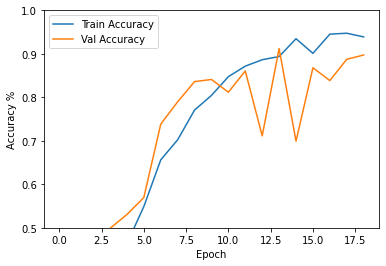

In [14]:
# plot accuracy hisory
import matplotlib.pyplot as plt
def plot_history(history):
 plt.figure()
 plt.xlabel('Epoch')
 plt.ylabel('Accuracy %')
 plt.plot(history.epoch, np.array(history.history['acc']),
 label='Train Accuracy')
 plt.plot(history.epoch, np.array(history.history['val_acc']),
 label = 'Val Accuracy')
 plt.legend()
 plt.ylim([0.5, 1])
plot_history(history)

# Custom Object Detection

## Data Pre-processing

In [0]:
def load_flowers(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load Flower data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

## Faster-RCNN implementation


## Single Shot Detector Implementation